In [1]:
%load_ext autoreload
%autoreload 2
%cd ..

/net/tscratch/people/plghpiotr


In [2]:
%cd cl-adaptation/

/net/tscratch/people/plghpiotr/cl-adaptation


In [3]:
import torch
from src.analysis import svd

torch.cuda.is_available()

True

In [4]:
# from src.analysis import core

# DEVICE = "cuda"

# path = "results/2024/04.24/13-34-11/2/cifar100_fixed_lwf"
# cfg = core.create_cfg(path)
# cfg.data.num_workers = 1
# data_factory = core.DataFactory(cfg)

In [37]:
import numpy as np


def calculate_svd_results(S):
    # Sort singular values in descending order
    sorted_indices = np.argsort(S)[::-1]
    singular_values_sorted = S[sorted_indices]

    # Calculate explained variance
    explained_variance = (singular_values_sorted**2) / np.sum(
        singular_values_sorted**2
    )
    cumulative_explained_variance = np.cumsum(explained_variance)

    return singular_values_sorted, explained_variance, cumulative_explained_variance

In [38]:
from collections import defaultdict
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd

from src.analysis import core
from src.analysis.svd import (
    calculate_eigens_directclr,
    torch_calculate_eigens_directclr,
)
import re

DEVICE = "cuda"


get_digits = lambda str: int(re.sub(r"\D", "", str))


def plot_eigenspectrum_v2(name_path: dict, device="cpu"):
    columns = len(name_path)

    plt.rcParams.update({"font.size": 16})

    fig, axs = plt.subplots(1, columns, dpi=100, figsize=(columns * 5, 1 * 5))

    # train_loader, _, test_loader, taskcla = data_factory[0]
    exp_analysis = defaultdict(list)

    for col, (exp_name, exp_path) in enumerate(name_path.items()):
        cfg = core.create_cfg(exp_path)
        cfg.data.num_workers = 1
        data_factory = core.DataFactory(cfg)
        train_loader, _, test_loader, taskcla = data_factory[0]
        model_factory = core.ModelFactory(cfg, exp_path, device=device)

        for task_idx, ckpt in enumerate(sorted(model_factory.ckpts)):
            assert task_idx == get_digits(ckpt.name)
            model = model_factory.create_model(task=task_idx, num_classes=taskcla[1])
            outs = core.get_activations(model.model, test_loader, device=device)
            embeddings = torch.vstack(list(outs.values()))

            eigs = torch_calculate_eigens_directclr(embeddings)
            eigs = eigs.cpu().detach().numpy()
            df = pd.DataFrame()
            # df["eigs"] = np.log(eigs / eigs[0])
            df["eigs"] = np.log(eigs)
            df["xs"] = list(range(len(eigs)))
            exp_analysis[exp_name].append(eigs)

            if len(name_path) > 1:
                ax = axs[col]
            else:
                ax = axs

            ax.plot(df["xs"].values, df["eigs"].values, label=f"Task {task_idx+1}")

        ax.legend(loc="upper right", fancybox=True, shadow=False)
        ax.set_title(exp_name)
        # ax.set_ylim([-10, 0.5])
        ax.set_ylim([-2, 3])
        # ax.set_xlim([-10, 400])
        ax.set_xlabel("Singular Value Rank Index")
        ax.grid()
        if col == 0:
            ax.set_ylabel("Log of normalized singular values")
        if col != 0:
            ax.set(ylabel="", yticklabels=[])

    fig.tight_layout()
    return exp_analysis

In [32]:
from pathlib import Path

p = Path("models/cifar100_5/resnet34")
expname_path = {}
for dir in p.iterdir():
    for i in dir.iterdir():
        path = i.readlink()
        exp_name = "_".join(i.parts[2:])
        expname_path[exp_name] = path

In [33]:
expname_path

{'resnet34_finetuning_reg': PosixPath('results/2024/04.24/13-35-10/0/cifar100_fixed_finetuning'),
 'resnet34_finetuning_noreg': PosixPath('results/2024/04.17/18-13-25/0/cifar100_fixed_finetuning_final_checkpoint'),
 'resnet34_ewc_reg': PosixPath('results/2024/04.24/13-35-10/4/cifar100_fixed_ewc'),
 'resnet34_ewc_noreg': PosixPath('results/2024/04.22/23-58-39/0/cifar100_fixed_ewc_final_checkpoint'),
 'resnet34_lwf_reg': PosixPath('results/2024/04.24/13-34-11/2/cifar100_fixed_lwf'),
 'resnet34_lwf_noreg': PosixPath('results/2024/04.17/18-14-14/0/cifar100_fixed_lwf_final_checkpoint'),
 'resnet34_replay_reg': PosixPath('results/2024/04.24/13-35-10/2/cifar100_fixed_finetuning'),
 'resnet34_replay_noreg': PosixPath('results/2024/04.17/18-13-25/1/cifar100_fixed_finetuning_final_checkpoint')}

In [34]:
finetuning_exps = {
    "resnet34_finetuning_reg": "results/2024/04.24/13-35-10/0/cifar100_fixed_finetuning",
    "resnet34_finetuning_noreg": "results/2024/04.17/18-13-25/0/cifar100_fixed_finetuning_final_checkpoint",
}

In [35]:
# ewc = Path("results/2024/04.24/13-35-10/4/cifar100_fixed_ewc")

# torch.load(ewc / "models" / "task3.ckpt", map_location=DEVICE)

Files already downloaded and verified
Files already downloaded and verified
<All keys matched successfully>


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 33.90it/s]


<All keys matched successfully>


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 35.71it/s]


<All keys matched successfully>


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 35.93it/s]


<All keys matched successfully>


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 35.80it/s]


<All keys matched successfully>


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 35.87it/s]


Files already downloaded and verified
Files already downloaded and verified
<All keys matched successfully>


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 35.68it/s]


<All keys matched successfully>


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 35.35it/s]


<All keys matched successfully>


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 35.50it/s]


<All keys matched successfully>


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 35.45it/s]


<All keys matched successfully>


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 35.36it/s]


Files already downloaded and verified
Files already downloaded and verified
<All keys matched successfully>


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 35.80it/s]


<All keys matched successfully>


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 35.94it/s]


<All keys matched successfully>


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 36.03it/s]


<All keys matched successfully>


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 35.77it/s]


<All keys matched successfully>


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 35.92it/s]


Files already downloaded and verified
Files already downloaded and verified
<All keys matched successfully>


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 35.80it/s]


<All keys matched successfully>


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 35.91it/s]


<All keys matched successfully>


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 35.97it/s]


<All keys matched successfully>


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 36.03it/s]


<All keys matched successfully>


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 35.26it/s]


Files already downloaded and verified
Files already downloaded and verified
<All keys matched successfully>


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 35.80it/s]


<All keys matched successfully>


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 35.84it/s]


<All keys matched successfully>


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 35.97it/s]


<All keys matched successfully>


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 35.75it/s]


<All keys matched successfully>


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 35.65it/s]


Files already downloaded and verified
Files already downloaded and verified
<All keys matched successfully>


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 35.88it/s]


<All keys matched successfully>


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 35.98it/s]


<All keys matched successfully>


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 35.63it/s]


<All keys matched successfully>


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 35.91it/s]


<All keys matched successfully>


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 35.81it/s]


Files already downloaded and verified
Files already downloaded and verified
<All keys matched successfully>


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 35.65it/s]


<All keys matched successfully>


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 35.78it/s]


<All keys matched successfully>


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 35.58it/s]


<All keys matched successfully>


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 35.72it/s]


<All keys matched successfully>


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 35.94it/s]


Files already downloaded and verified
Files already downloaded and verified
<All keys matched successfully>


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 35.63it/s]


<All keys matched successfully>


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 35.75it/s]


<All keys matched successfully>


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 35.70it/s]


<All keys matched successfully>


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 35.55it/s]


<All keys matched successfully>


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 35.51it/s]


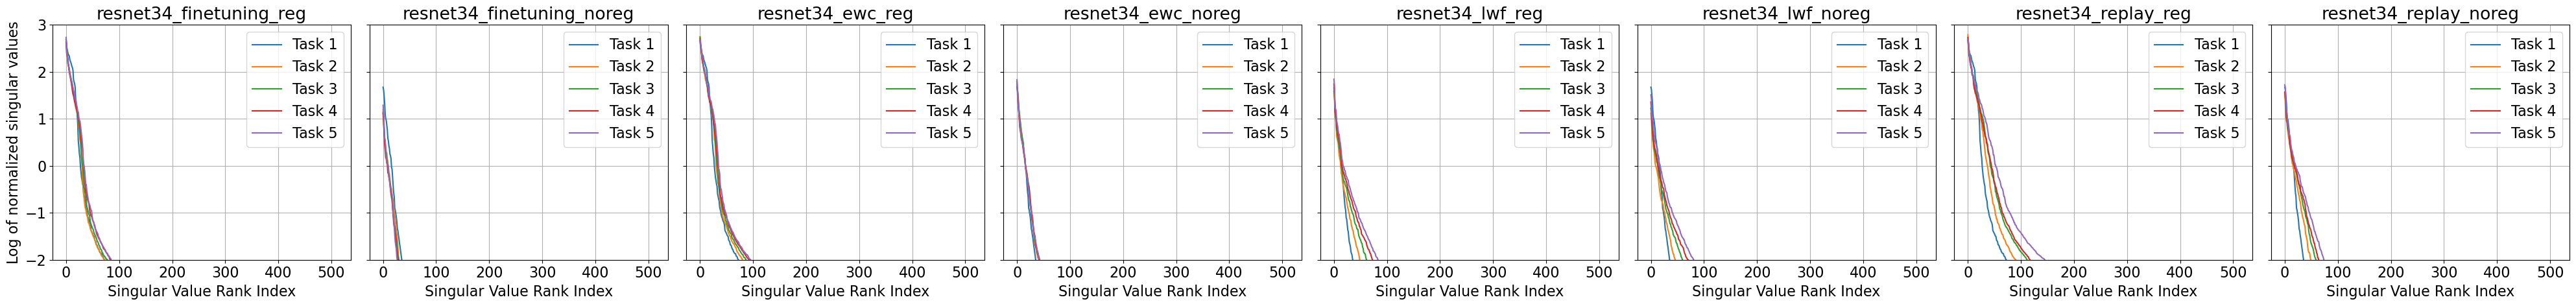

In [73]:
e_a = plot_eigenspectrum_v2(expname_path, device=DEVICE)
# plot_eigenspectrum_v2(
#     {
#         "resnet34_ewc_reg": "results/2024/04.24/13-35-10/4/cifar100_fixed_ewc",
#     },
#     device=DEVICE,
# )

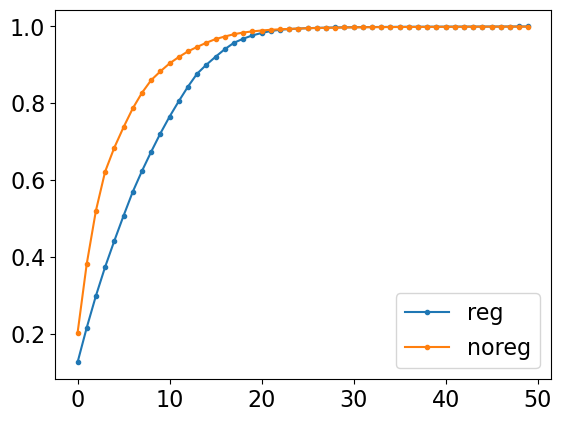

In [83]:
from functools import partial


plot = partial(plt.plot, marker=".")
plot(calculate_svd_results(e_a["resnet34_finetuning_reg"][0])[2][:50])
plot(calculate_svd_results(e_a["resnet34_finetuning_noreg"][0])[2][:50])
plt.legend(["reg", "noreg"])

In [105]:
def plot_explained_variance(name):
    # Assuming e_a is your dictionary of experiment results

    # Create subplots
    fig, axs = plt.subplots(1, 5, figsize=(20, 5))

    for i in range(5):
        # Get cumulative explained variance for each experiment iteration
        cumulative_variance_reg = calculate_svd_results(e_a[f"resnet34_{name}_reg"][i])[
            2
        ][:50]
        cumulative_variance_noreg = calculate_svd_results(
            e_a[f"resnet34_{name}_noreg"][i]
        )[2][:50]

        # Plot cumulative explained variance for each experiment iteration
        axs[i].plot(cumulative_variance_reg, label="reg", marker=".")
        axs[i].plot(cumulative_variance_noreg, label="noreg", marker=".")
        axs[i].set_title(f"Experiment {i+1}")
        axs[i].set_xlabel("Singular Value Index")
        axs[i].set_ylabel("Cumulative Explained Variance")
        axs[i].legend()
        axs[i].grid()
        print(
            f"{sum((cumulative_variance_reg < 0.95))=} {sum((cumulative_variance_noreg < 0.95))=}"
        )
        # axs[i].set_xscale("log")
    plt.suptitle(name)
    plt.tight_layout()
    plt.show()

sum((cumulative_variance_reg < 0.95))=17 sum((cumulative_variance_noreg < 0.95))=14
sum((cumulative_variance_reg < 0.95))=20 sum((cumulative_variance_noreg < 0.95))=16
sum((cumulative_variance_reg < 0.95))=20 sum((cumulative_variance_noreg < 0.95))=14
sum((cumulative_variance_reg < 0.95))=22 sum((cumulative_variance_noreg < 0.95))=15
sum((cumulative_variance_reg < 0.95))=22 sum((cumulative_variance_noreg < 0.95))=13


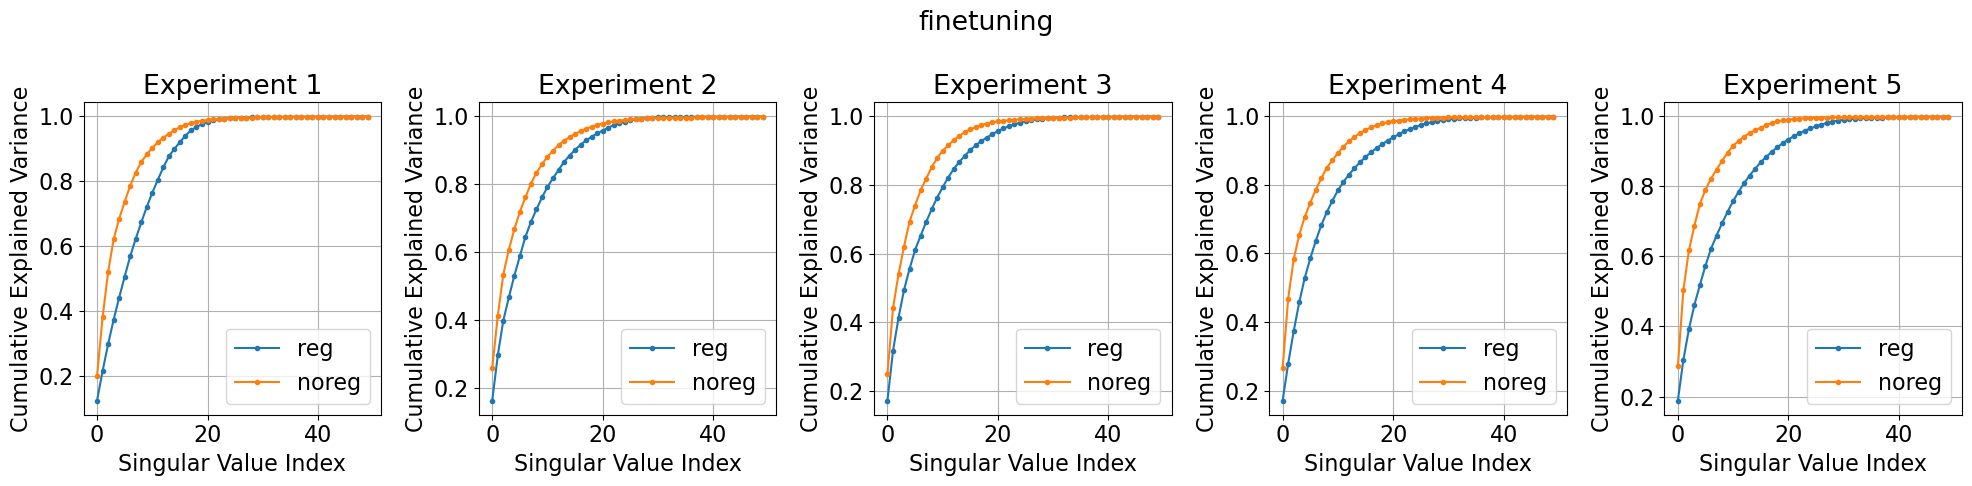

In [106]:
plot_explained_variance("finetuning")

sum((cumulative_variance_reg < 0.95))=13 sum((cumulative_variance_noreg < 0.95))=14
sum((cumulative_variance_reg < 0.95))=17 sum((cumulative_variance_noreg < 0.95))=22
sum((cumulative_variance_reg < 0.95))=21 sum((cumulative_variance_noreg < 0.95))=26
sum((cumulative_variance_reg < 0.95))=24 sum((cumulative_variance_noreg < 0.95))=29
sum((cumulative_variance_reg < 0.95))=26 sum((cumulative_variance_noreg < 0.95))=30


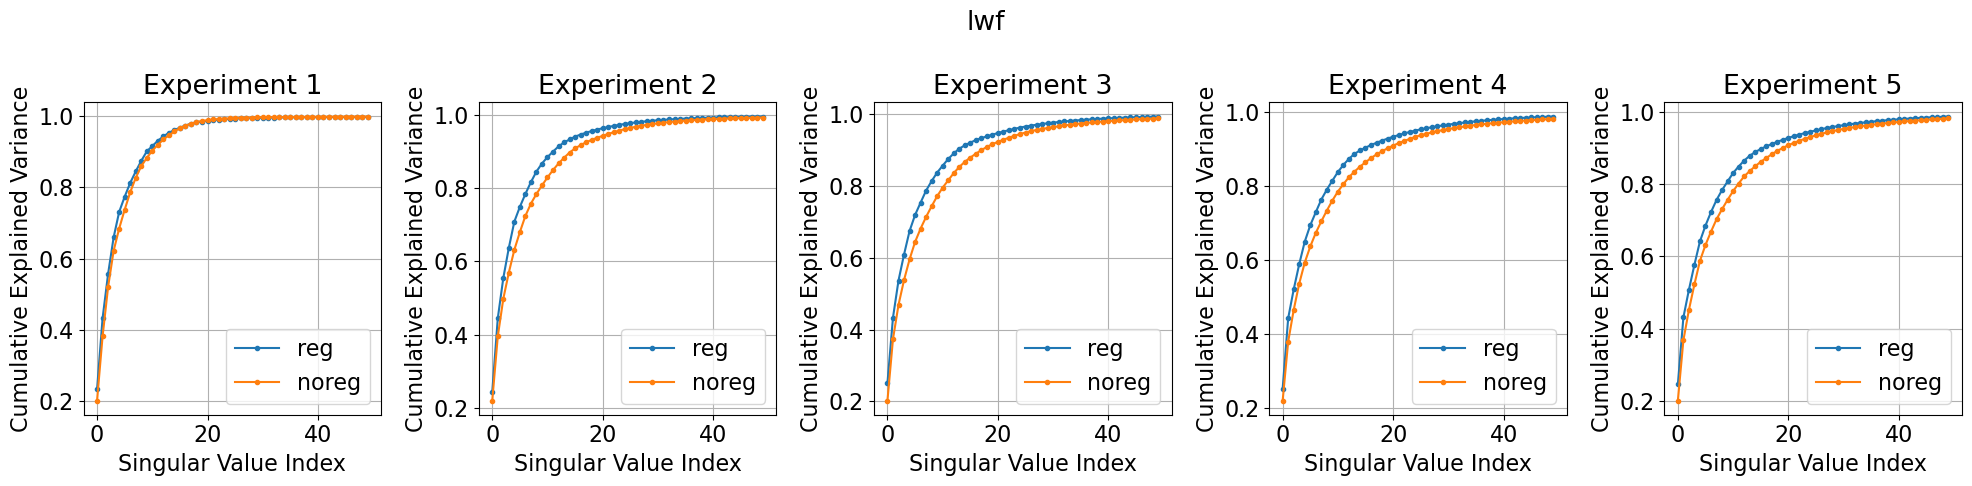

In [107]:
plot_explained_variance("lwf")

sum((cumulative_variance_reg < 0.95))=17 sum((cumulative_variance_noreg < 0.95))=14
sum((cumulative_variance_reg < 0.95))=20 sum((cumulative_variance_noreg < 0.95))=15
sum((cumulative_variance_reg < 0.95))=21 sum((cumulative_variance_noreg < 0.95))=15
sum((cumulative_variance_reg < 0.95))=21 sum((cumulative_variance_noreg < 0.95))=16
sum((cumulative_variance_reg < 0.95))=23 sum((cumulative_variance_noreg < 0.95))=15


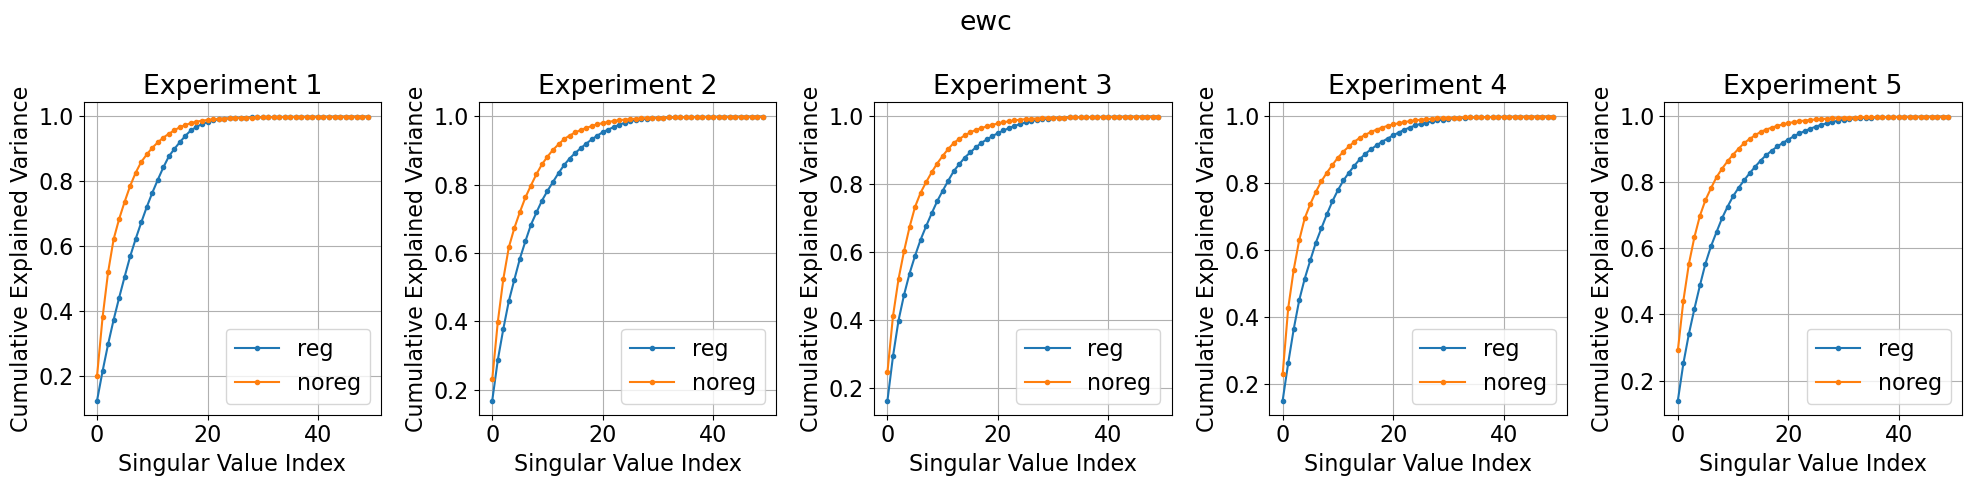

In [108]:
plot_explained_variance("ewc")

sum((cumulative_variance_reg < 0.95))=17 sum((cumulative_variance_noreg < 0.95))=14
sum((cumulative_variance_reg < 0.95))=21 sum((cumulative_variance_noreg < 0.95))=21
sum((cumulative_variance_reg < 0.95))=26 sum((cumulative_variance_noreg < 0.95))=24
sum((cumulative_variance_reg < 0.95))=26 sum((cumulative_variance_noreg < 0.95))=27
sum((cumulative_variance_reg < 0.95))=33 sum((cumulative_variance_noreg < 0.95))=28


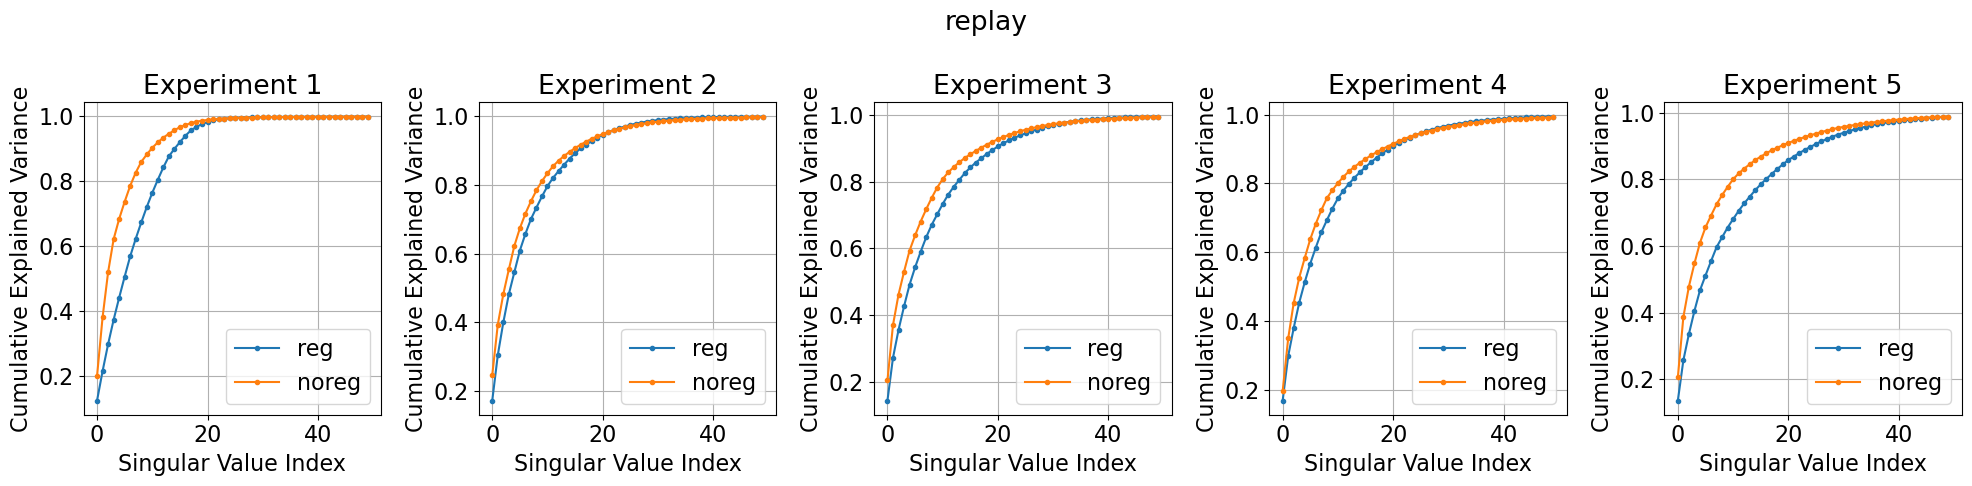

In [109]:
plot_explained_variance("replay")

In [110]:
ex = torch.rand((255, 255, 255))

In [113]:
ex.mean(0)

tensor([[0.4786, 0.4879, 0.4976,  ..., 0.4980, 0.5182, 0.4922],
        [0.5065, 0.4807, 0.4988,  ..., 0.4569, 0.5254, 0.4926],
        [0.4727, 0.4583, 0.5060,  ..., 0.5088, 0.4774, 0.4671],
        ...,
        [0.4766, 0.4947, 0.5077,  ..., 0.4988, 0.4901, 0.5161],
        [0.4989, 0.5131, 0.4720,  ..., 0.4911, 0.4922, 0.4835],
        [0.4774, 0.5053, 0.4629,  ..., 0.5070, 0.5015, 0.4748]])